# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import pickle
from skimage import transform
import cv2
import matplotlib.image as mpimg

In [2]:
def load_data(training_file, testing_file):
    """ 
    loads data from pickle
    divides training data and set used for training and set used for validation
    returns training, validation and test sets (images and corresponding classes)
    """
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
        
    X_train_all, y_train_all = train['features'], train['labels']
    n_train_all = X_train_all.shape[0]
    
    # rearrange data
    perm = np.arange(n_train_all)
    np.random.shuffle(perm)
    n_train = round(n_train_all*0.9)
    
    # Get the train images from the overall set.
    X_train = X_train_all[perm][:n_train]
    # Get the validation images from the overall set.
    y_train = y_train_all[perm][:n_train]
    
    # Get the train images from the overall set.
    X_val = X_train_all[perm][n_train:]
    # Get the validation images from the overall set.
    y_val = y_train_all[perm][n_train:]
    
    X_test, y_test = test['features'], test['labels']

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
# load data

training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'
X_train_base, y_train_base, X_val, y_val, X_test, y_test = load_data(training_file, testing_file)

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train_base.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train_base.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train_base))

# number of pixels in each dimension
img_size = X_train_base.shape[1]
    
# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size
    
# Number of colour channels for the images
num_channels = X_train_base.shape[3]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Image shape flattened =", img_size_flat)
print("Number of channels = ", num_channels)
print("Number of classes =", n_classes)

Number of training examples = 35288
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Image shape flattened = 1024
Number of channels =  3
Number of classes = 43


In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def plot_all_classes(X_data, y_data):
    """
    plots all classes to get an overview
    """
    u,indices = np.unique(y_data, return_index=True)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(7,7, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, ax in enumerate(axes.flat):

        # Plot image.
        if i < len(indices):
            ax.imshow(X_data[indices][i])
    
            xlabel = "True: {0}".format(y_data[indices][i])
            
            # Show classes as label on x-axis
            ax.set_xlabel(xlabel)
            
            # Remove ticks
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    
    plt.show()
    
    
def plot_images(images, cls_true, cls_pred=None):
    """
    plot 9 images with true classes
    """
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])#.reshape(image_shape))#, cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show classes as label on x-axis
        ax.set_xlabel(xlabel)
        
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

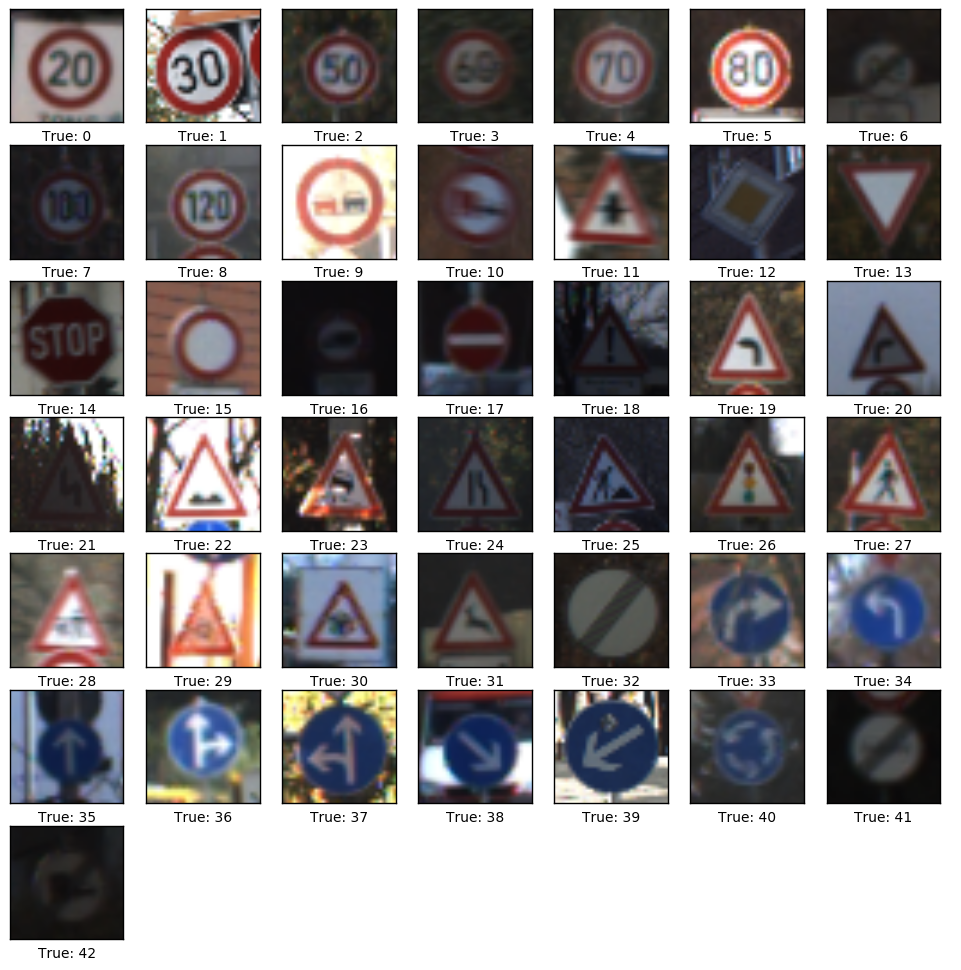

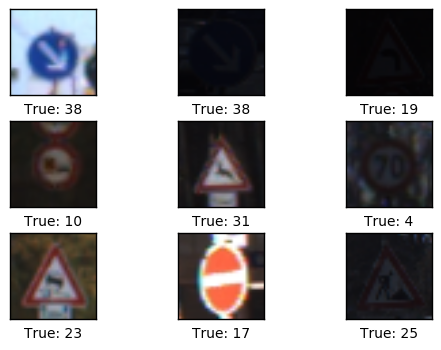

In [6]:
# Plot all different classes to get an overview
plot_all_classes(X_train_base, y_train_base)

# Get some random images
perm = np.arange(n_train)
np.random.shuffle(perm)
    
# Get the first images from the test-set.
images_rand = X_train_base[perm][0:9]

# Get the true classes for those images.
cls_true_rand = y_train_base[perm][0:9]
    
# Plot the images and labels using our helper-function above.
plot_images(images=images_rand, cls_true=cls_true_rand)

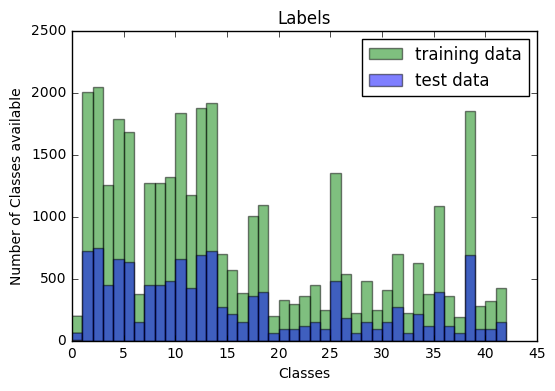

In [7]:
# plotting classes
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(y_train_base, y_train_base.max(), facecolor='green', alpha=0.5, label='training data')
n, bins, patches = ax.hist(y_test, y_test.max(), facecolor='blue', alpha=0.5, label='test data')
plt.xlabel('Classes')
plt.ylabel('Number of Classes available')
plt.title('Labels')
plt.legend()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
def dense_to_one_hot(labels_dense, num_classes=10):
  """
  Convert class labels from scalars to one-hot vectors
  """
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

  return labels_one_hot

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
- labels need to be converted into a matrix with zeros and ones to indicate for the correct class

In [9]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def shear_images(image_list, shear_factor = 0.2, enable_plot = False):
    """
    sheares a list of images (numpy arrays) and returns a new list of sheared images
    """
    sheared_image_list = []
    afine_tf = transform.AffineTransform(shear=shear_factor)
    for image in image_list:
        modified = transform.warp(image, afine_tf)
        sheared_image_list.append(modified)
        
        if enable_plot:
            fig, axes = plt.subplots(1,2)
            axes[0].imshow(image)
            axes[1].imshow(modified)
            plt.show()
        
    return np.array(sheared_image_list)

In [10]:
X_train_sheared_pos = shear_images(X_train_base, 0.05)
X_train_sheared_neg = shear_images(X_train_base, -0.05)
    
# numpy array will come as float. as imshow results in strange behaviour, with float, convert it back to unsigned int
X_train = np.uint8(np.concatenate((X_train_base, X_train_sheared_pos, X_train_sheared_neg), axis=0))
y_train = np.uint8(np.concatenate((y_train_base, y_train_base, y_train_base)))

In [11]:
# get a matrix with zeros or ones to indicate for class

y_train_hot_encoded = dense_to_one_hot(y_train, n_classes)
y_val_hot_encoded = dense_to_one_hot(y_val, n_classes)
y_test_hot_encoded = dense_to_one_hot(y_test, n_classes)

In [12]:
# update number of training examples
n_train = X_train.shape[0]

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
- training data provided is divided again into data used for training and data used for validation to elimate optimazation/validation bias
- implented in function load_data() stated above

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### helper functions for new_conv_layer, flatten_layer and new_fc_layer have been taken from 
# https://github.com/Hvass-Labs/TensorFlow-Tutorials

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

    # Create new biases, one for each filter.
    biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights
    
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
    
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    shape = [num_inputs, num_outputs]
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [14]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.


### Placeholder variables    
x_image = tf.placeholder(tf.float32, [None, img_size, img_size, num_channels], name='x_image')

y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)


### Convolutional Layer 1
# - takes x_image as input and creates num_filters1 different filters, 
#   each having width and height equal to filter_size1
# - down-sample the image so it is half the size by using 2x2 max-pooling
layer_conv1, weights_conv1 = new_conv_layer(input = x_image,
               num_input_channels = num_channels,
               filter_size = filter_size1,
               num_filters = num_filters1,
               use_pooling = True)

### Convolutional Layer 2
# - takes as input the output from the first convolutional layer
# - number of input channels corresponds to number of filters in first convolutional layer.
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
               num_input_channels=num_filters1,
               filter_size=filter_size2,
               num_filters=num_filters2,
               use_pooling=True)

### Flatten layer
layer_flat, num_features = flatten_layer(layer_conv2)

# Fully-connected layer 1
# - input is the flattened layer from the previous convolution
# - number of neurons or nodes in fully-connected layer is fc_size
layer_fc1 = new_fc_layer(input=layer_flat,
                     num_inputs=num_features,
                     num_outputs=fc_size,
                     use_relu=True)

# Fully-connected layer 2
# - another fully-connected layer that outputs vectors of length 10 
# for determining which of the 10 classes the input image belongs to. 
# - ReLU is not used in this layer
layer_fc2 = new_fc_layer(input=layer_fc1,
                     num_inputs=fc_size,
                     num_outputs=n_classes,
                     use_relu=False)

# extract single class allocation from neural network
y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, dimension=1)

# calculate costs
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

cost = tf.reduce_mean(cross_entropy)

# initialize optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# set up accuracy calculation
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
- architecture is shown in picture below

- two convolutional layers are used

- first conv layer takes image as input and creates 16 different filters with size 5x5 pixels (!!! both changeable in order to improve accuracy)
    - down-samples the image so it is half the size by using 2x2 max-pooling
- second conv layer takes that as an input (16x16 pixels, 16 channels) and creates 36 filters with size 5x5 pixels (!!! both settings changeable in order to improve accuracy)
    - again down-sampled to half of its size using 2x2 max-pooling
- output is flattened
- flattened layer is fed into fully connected layer with 128 (!!! changeable in order to improve accuracy) neurons
- another fully connected layer is used to get from 128 features (neurons) to 43 features (which is the number of classes in the dataset)
- output is then densed to one single class allocation using softmax

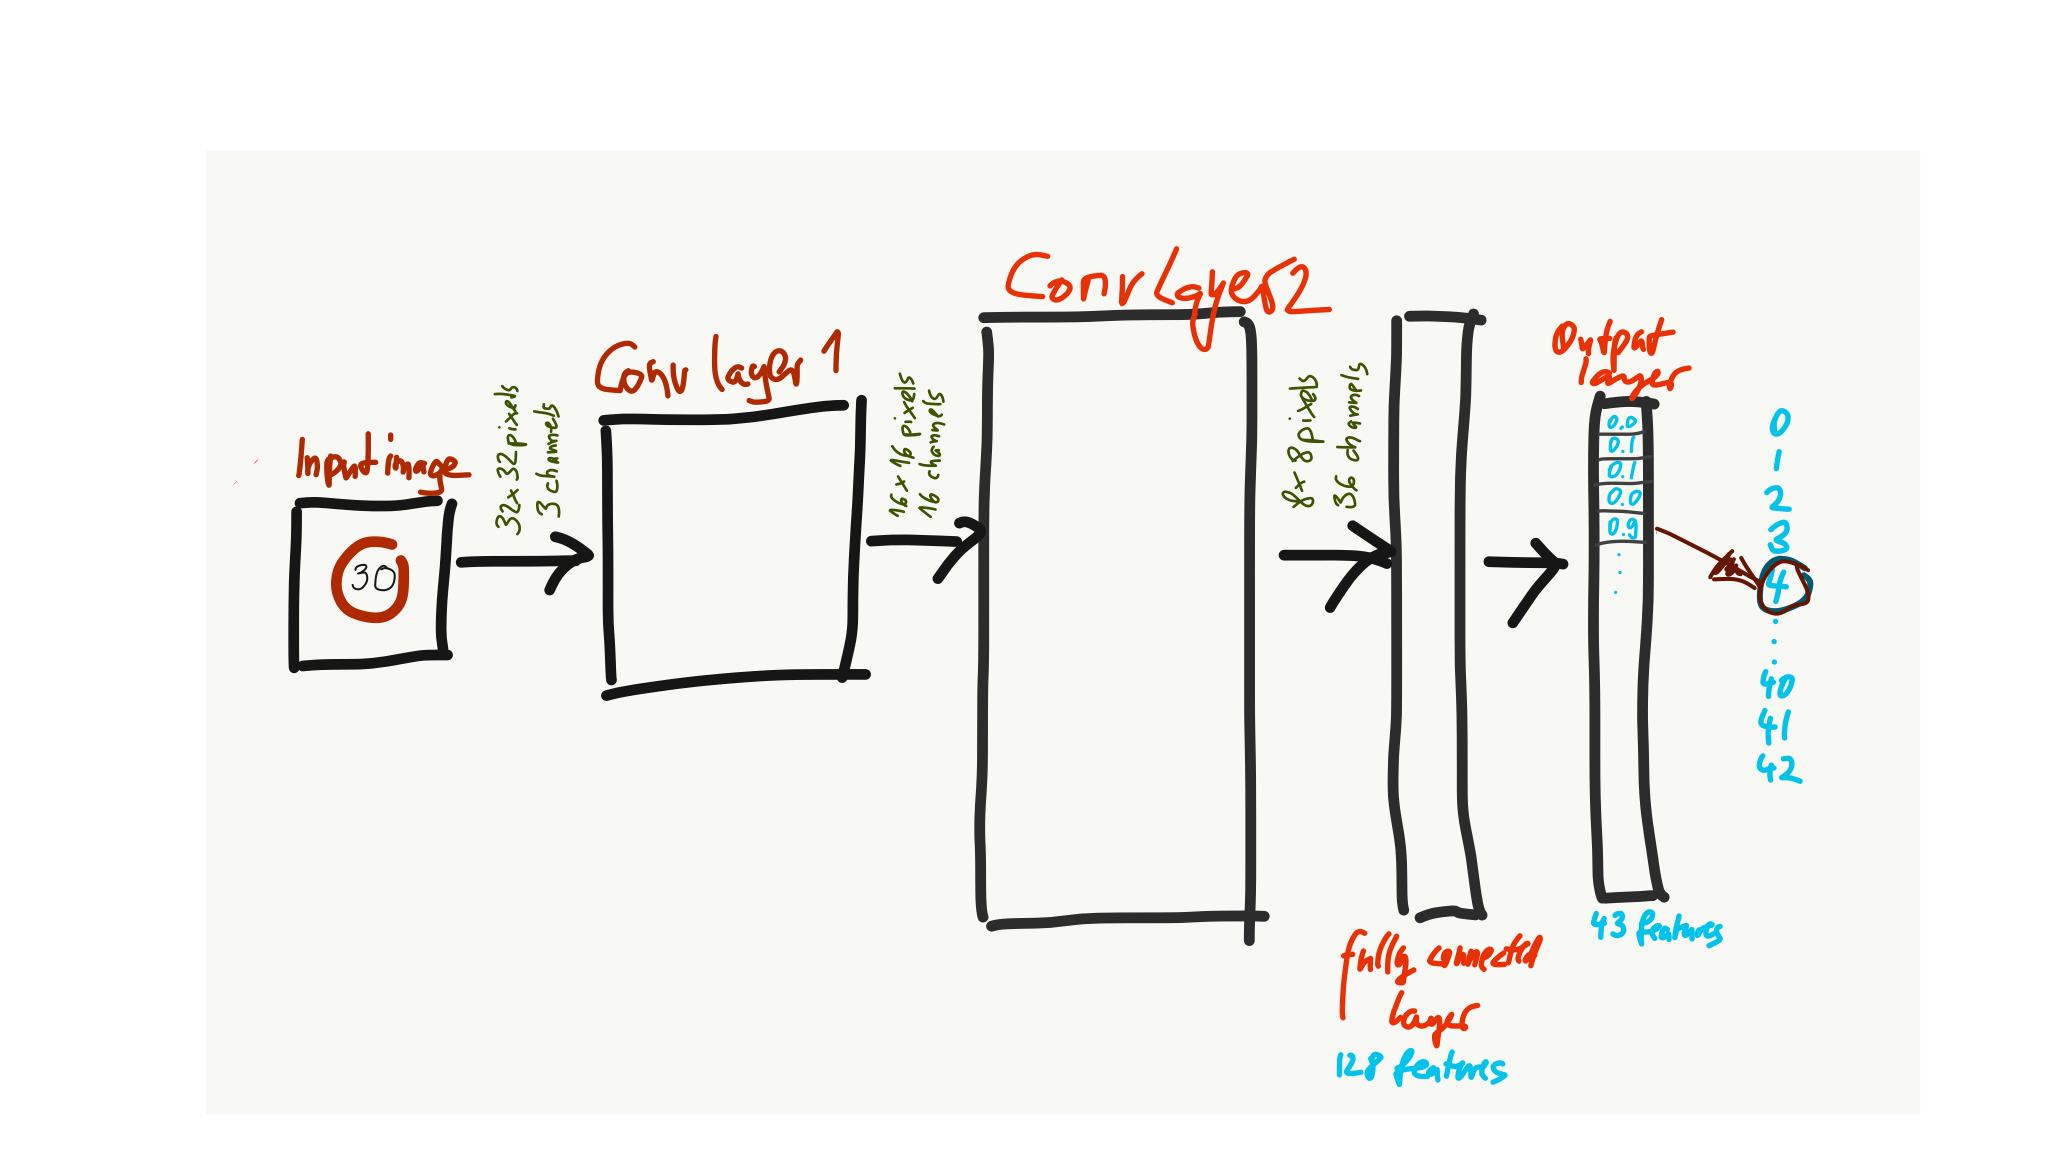

In [15]:
from IPython.display import Image
Image('architecture.png')

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.

def optimize(X_train, y_train_hot_encoded, train_batch_size, epochs):
    # Ensure we update the global variable rather than a local copy.
#    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

#    for i in range(total_iterations,
#                   total_iterations + num_iterations):
    for epoch_i in range(epochs):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        
        features, labels = new_epoch(X_train, y_train_hot_encoded)
        
        for x_batch, y_true_batch in batches(train_batch_size, features, labels):

            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x_image: x_batch, y_true: y_true_batch}
    
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)

        acc = session.run(accuracy, feed_dict=feed_dict_train)

        # Message for printing.
        msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

        # Print it.
        print(msg.format(epoch_i + 1, acc))

    # Update the total number of iterations performed.
#    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [17]:
# helper functions for plot_example_errors, plot_confusion_matrix and print_test_accuracy have been taken from 
# https://github.com/Hvass-Labs/TensorFlow-Tutorials

def plot_example_errors(X_test, y_test, cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    
    if len(cls_pred)>=9:
        # Plot the first 9 images.
        plot_images(images=images[0:9],
                    cls_true=cls_true[0:9],
                    cls_pred=cls_pred[0:9])
    else:
        for i, image in enumerate(images):
            plt.imshow(image)#.reshape(image_shape))#, cmap='binary')

            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

            # Show classes as label on x-axis
            plt.xlabel(xlabel)
            
            # Remove ticks
            plt.xticks([])
            plt.yticks([])
            plt.show()
    
def plot_confusion_matrix(y_test, cls_pred, n_classes):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_test# data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    #plt.figure(figsize=(16, 8))
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the confusion matrix as an image.
    cbar = ax.matshow(cm)

    # Make various adjustments to the plot.
    fig.colorbar(cbar)
    tick_marks = np.arange(n_classes)
    ax.set_xticks(tick_marks, range(n_classes))
    ax.set_yticks(tick_marks, range(n_classes))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    


def print_test_accuracy(X_test, y_test, y_test_hot_encoded, y_pred_cls, n_classes, show_example_errors=False,
                        show_confusion_matrix=False):

    """
    determine accuracy of conv net when test set is used
    """
    # Split the test-set into smaller batches of this size.
    test_batch_size = 256
    
    # Number of images in the test-set.
    num_test = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test_hot_encoded[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x_image: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_test

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} (correct: {1}/ tested: {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(X_test, y_test, cls_pred, correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(y_test, cls_pred, n_classes)

In [18]:
def new_epoch(X_data, y_data):

    # Get some random images
    n_data = X_data.shape[0]

    perm = np.arange(n_data)
    np.random.shuffle(perm)
    
    # Get the first images from the test-set.
    images_rand = X_data[perm]

    # Get the true classes for those images.
    cls_true_rand = y_data[perm]
    
    #shuffle data.x and data.y while retaining relation
    return [images_rand, cls_true_rand]

def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

Optimization Iteration:      1, Training Accuracy:  37.5%
Time usage: 0:04:21
Validation Set
Accuracy on Test-Set: 76.2% (correct: 2987/ tested: 3921)
Example errors:


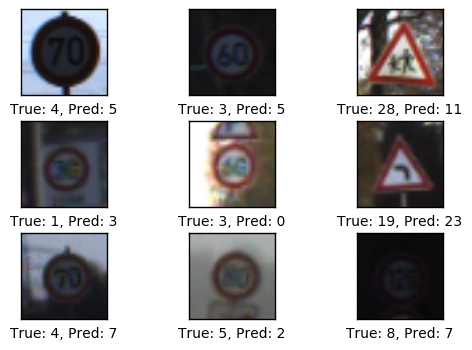

Confusion Matrix:
[[  4   6   0 ...,   0   0   0]
 [  3 135  17 ...,   0   0   0]
 [  0   7 153 ...,   0   0   0]
 ..., 
 [  2   0   0 ...,  27   0   0]
 [  0   1   0 ...,   3  15   0]
 [  0   0   0 ...,   2   0   6]]


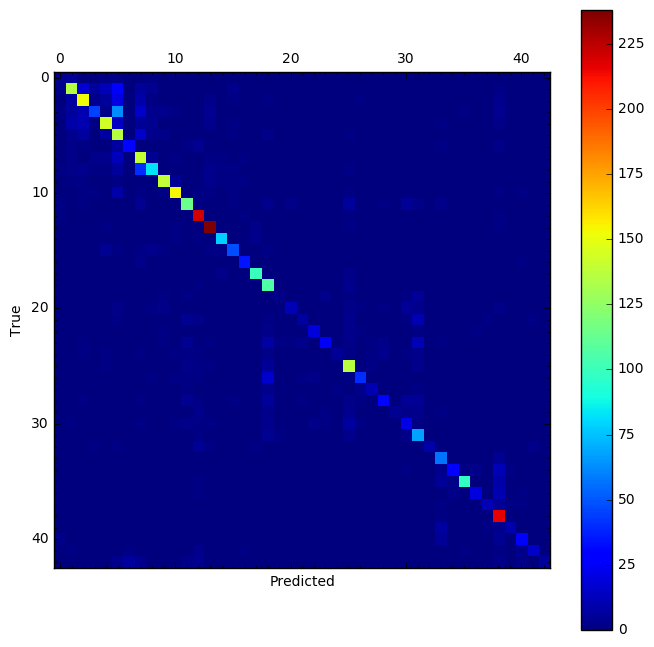

Test Set
Accuracy on Test-Set: 67.2% (correct: 8489/ tested: 12630)
Example errors:


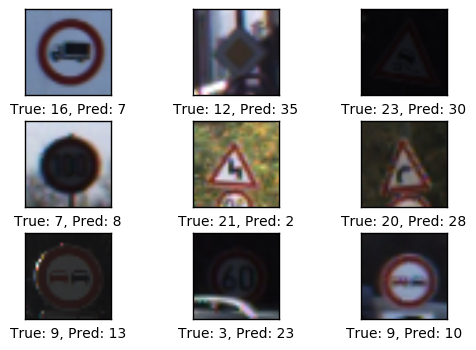

Confusion Matrix:
[[  0  30   3 ...,   0   0   0]
 [  6 427 108 ...,   0   0   0]
 [  7  58 540 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  53   0   0]
 [  0   0   0 ...,   4   4   6]
 [  0   0   0 ...,   2   7  19]]


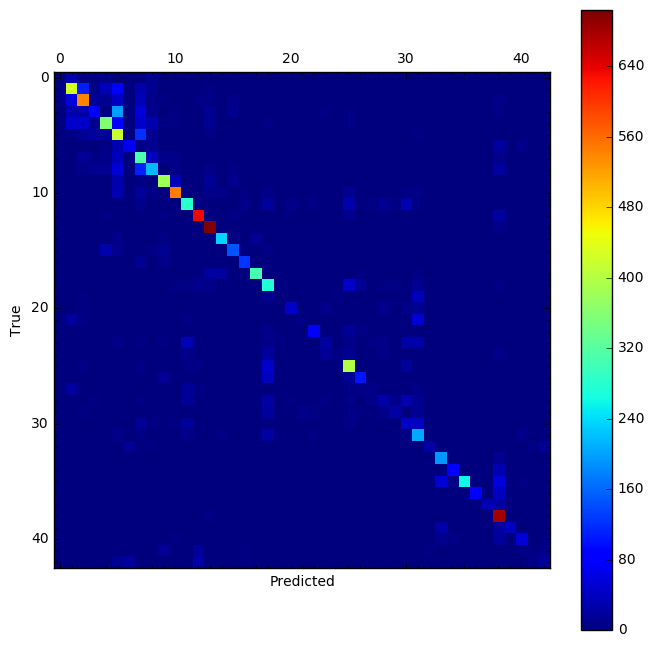

In [19]:
### Tensor Flow Run
session = tf.Session()

session.run(tf.initialize_all_variables())

# split training data into batches that are then feeded into the network
train_batch_size = 64

# run optimization
optimize(X_train, y_train_hot_encoded, train_batch_size, 1)

print('Validation Set')
print_test_accuracy(X_val, y_val, y_val_hot_encoded, y_pred_cls, n_classes, show_example_errors=True, show_confusion_matrix=True)

print('Test Set')
print_test_accuracy(X_test, y_test, y_test_hot_encoded, y_pred_cls, n_classes, show_example_errors=True, show_confusion_matrix=True)

#session.close()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
- AdamOptimizer has been used in combination with a constant learning rate
- used 1 epoch here (no significant improvement on overall accuracy after that)
- 10 epoch result in a test accuracy above 90%
- set batch size to 64 due to memory constrains

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
- used a convolutional network, as it is more capabable on detecting patterns in images than a normal neural network

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [20]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def resize_image(image_name, enable_plot = False):
    image = mpimg.imread(image_name)
    
    image_resized = scipy.misc.imresize(image, (32, 32))
    if enable_plot:
        plt.imshow(image_resized)
    return image_resized

In [21]:
dict_traffic_signs = {
    'traffic_signs_images_square/einbahnstrasse_17_1.png': 17,
    'traffic_signs_images_square/einbahnstrasse_17.png': 17,
    'traffic_signs_images_square/vorfahrtgewaehren_13_1.png': 13,
    'traffic_signs_images_square/vorfahrtgewaehren_13.png': 13,
    'traffic_signs_images_square/vorfahrtsschild_12_1.png': 12,
    'traffic_signs_images_square/vorfahrtsschild_12_2.png': 12,
    'traffic_signs_images_square/vorfahrtsschild_12_3.png': 12,
    'traffic_signs_images_square/vorfahrtsschild_12_4.png': 12,
    'traffic_signs_images_square/vorfahrtsschild_12_5.png': 12,
    'traffic_signs_images_square/vorfahrtsschild_12.png': 12,
                    }
    
image_list_web = []
label_list_web = []

for image_name, label in dict_traffic_signs.items():        
    image = resize_image(image_name)
    image_list_web.append(image)
    label_list_web.append(label)
    
X_web = np.array(image_list_web)
y_web = np.array(label_list_web)
y_web_hot_encoded = dense_to_one_hot(y_web, n_classes)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [22]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
X_web_selected = X_web[0:5]
y_web_selected = y_web[0:5]
y_web_selected_hot_encoded = y_web_hot_encoded[0:5]
print_test_accuracy(X_web_selected, y_web_selected, y_web_selected_hot_encoded, y_pred_cls, n_classes, show_example_errors=False, show_confusion_matrix=False)


Accuracy on Test-Set: 100.0% (correct: 5/ tested: 5)


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
- results for images taken from web appear to be good
- improvements could be made by only using gray images on conv net
- this would make the model more robust against changes in light, also original color of sign can change slightly

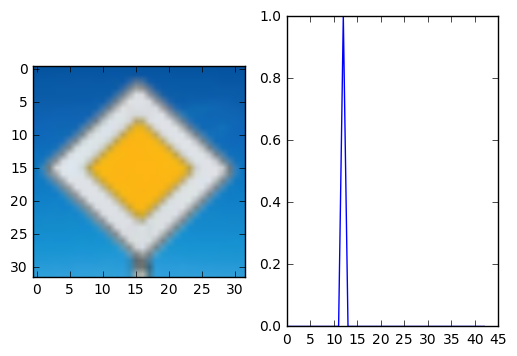

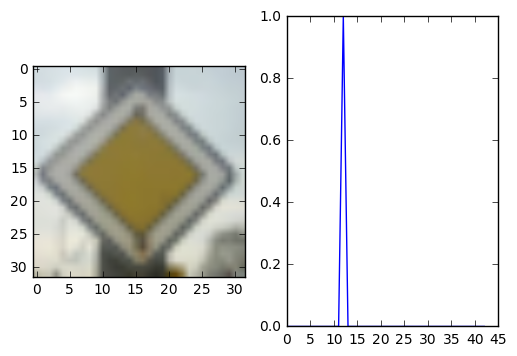

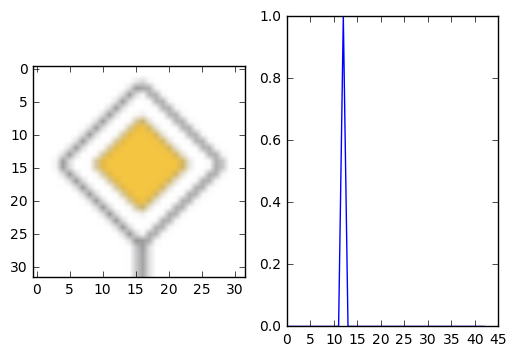

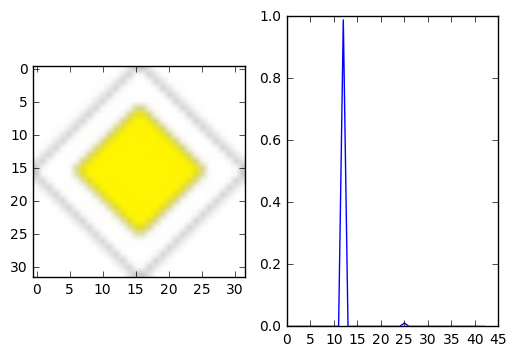

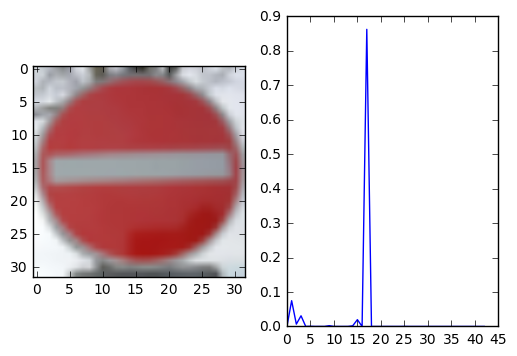

In [23]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
feed_dict = {x_image: X_web_selected,
             y_true: y_web_selected_hot_encoded}

y_web_pred = session.run(y_pred, feed_dict=feed_dict)

for i, image in enumerate(X_web_selected):
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(image)
    axes[1].plot(y_web_pred[i])
    plt.show()
    

# Picture  0


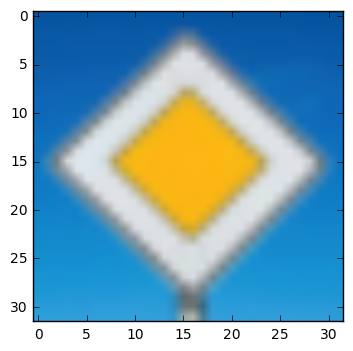

Probability of prediction: [  1.00000000e+00   6.86056634e-09   5.66070671e-12   1.02005785e-15
   1.95873312e-16]
Corresponding classes: [12 10 25  8 11]
True class: 12

# Picture  1


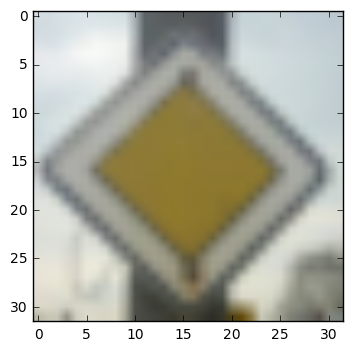

Probability of prediction: [  9.99795496e-01   1.23043792e-04   3.41224040e-05   2.30203714e-05
   7.57135786e-06]
Corresponding classes: [12 25 26 29 18]
True class: 12

# Picture  2


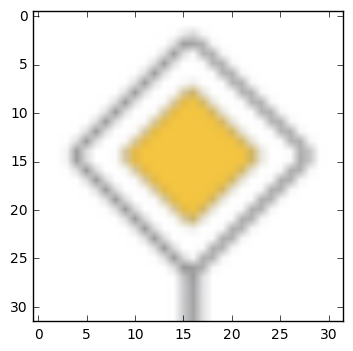

Probability of prediction: [  9.99999642e-01   1.87982323e-07   1.77039922e-07   1.27249260e-08
   1.18513919e-08]
Corresponding classes: [12 25 20 18 10]
True class: 12

# Picture  3


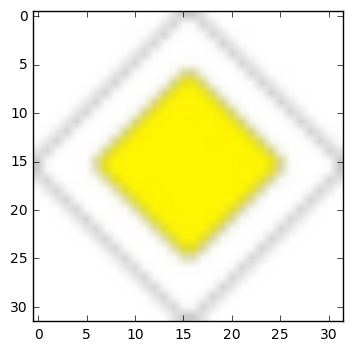

Probability of prediction: [  9.88864064e-01   1.09505085e-02   1.18355587e-04   3.85704079e-05
   9.93046160e-06]
Corresponding classes: [12 25 29 20  6]
True class: 12

# Picture  4


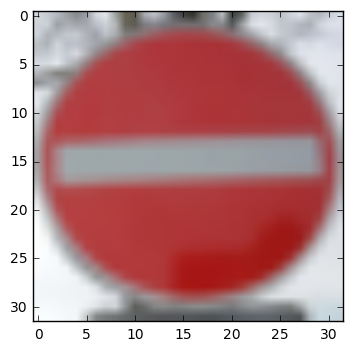

Probability of prediction: [ 0.86257082  0.07476182  0.03094009  0.0197334   0.00673012]
Corresponding classes: [17  1  3 15  2]
True class: 17



In [24]:
top_k = tf.nn.top_k(y_web_pred, k=5)
[res_top_k, ind_top_k] = session.run(top_k, feed_dict=feed_dict)

for i, res_top in enumerate(res_top_k):
    
    print('# Picture  '+ str(i))
    plt.imshow(X_web_selected[i])
    plt.show()
    print('Probability of prediction: ' + str(res_top))
    print('Corresponding classes: ' + str(ind_top_k[i]))
    print('True class: ' + str(y_web_selected[i]) + '\n')

**Answer:**

- detection of picture one (one-way) does provide correct results

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.